# Dịch văn bản (Vietnamese -> English) với attention model

Project này ta sẽ huấn luyện mô hình sequence to sequence (seq2seq) để dịch từ tiếng Việt sang tiếng Anh.

Sau khi huấn luyện mô hình , ta sẽ có thể nhập một câu tiếng Việt, chẳng hạn như "tôi tính đi ra biển chơi nhưng trời lại bắt đầu mưa", Và hy vọng model sẽ trả lại bản dịch tiếng Anh: "i was planning on going to the beach today but then it started to rain".

Trước khi bắt đầu ta sẽ import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import time
import os
import re
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import tensorflow as tf
from tensorflow import keras
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

## Load và tiền xử lý tập dữ liệu

Ta sẽ sử dụng tập dữ liệu "vie.txt". Tập dữ liệu này chứa các cặp dịch ngôn ngữ ở định dạng:

```
i was planning on going to the beach today but then it started to rain  tôi tính đi ra biển chơi nhưng trời lại bắt đầu mưa
```

In [2]:
with open('vie.txt','r',encoding="UTF-8") as f:
    data = f.read().split("\n")

In [3]:
print("Tập dữ liệu này bao gồm {} cặp Anh-Viêt".format(len(data)))
print("5 cặp đầu tiên sẽ có dạng: \n")
data[:5]

Tập dữ liệu này bao gồm 4083 cặp Anh-Viêt
5 cặp đầu tiên sẽ có dạng: 



['Run!\tChạy!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1541945 (Aomori)',
 'Help!\tGiúp tôi với!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #5489308 (phuc)',
 'Hello!\tChào bạn.\tCC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #510482 (tucm)',
 'Hurry!\tNhanh lên nào!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1182334 (Hideousss) & #5489313 (phuc)',
 'Eat it.\tĂn đi.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4768107 (garborg) & #8957153 (dotheduyet1999)']

Như ta thấy ở trên tập dữ liệu trông rất lộn xộn, ta sẽ phải thực hiện bước làm sạch dữ liệu và đưa nó về định dạng phù hợp với model

**Tiền xử lý dữ liệu**

1. Thêm mã thông báo "start" và "end" cho mỗi câu để model biết được khi nào bắt đàu và kết thúc của một câu.
2. Làm sạch các câu bằng cách loại bỏ các ký tự đặc biệt.
3. Tạo chỉ mục từ và chỉ mục từ đảo ngược (ánh xạ vocab từ word → id và id → word).
4. Chèn thêm 0 để mỗi ví dụ có độ dài bằng nhau (độ dài tối đa của mỗi bản dịch).

In [4]:
# Chuyển đổi tệp unicode thành ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) 
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = w.replace(".","")
    w = w.replace("!"," !")
    w = w.replace("?"," ?")
    w = w.replace("-"," ")
    w = w.replace(",","")
    w = w.replace(":"," ")
    w = w.replace("€","")
    w = w.replace("'"," ")
    w = w.lower()
    w = re.sub(r'[" "]+', " ", w)
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
# Chia dữ liệu thành list và loại bỏ chỉ số cuối cùng của từng phần tử (Tên tác giả của từng câu)
def processing_data(data):
    
    for i in range(len(data)):
        data[i] = data[i].split("\t")
        
    for i in range(len(data)):
        del(data[i][-1])
    
    return data

In [6]:
data = processing_data(data)

In [7]:
data[:5]

[['Run!', 'Chạy!'],
 ['Help!', 'Giúp tôi với!'],
 ['Hello!', 'Chào bạn.'],
 ['Hurry!', 'Nhanh lên nào!'],
 ['Eat it.', 'Ăn đi.']]

In [8]:
# Áp dụng preprocess_sentence cho từng bản dịch
for i in range(len(data)):
    data[i][0] = preprocess_sentence(data[i][0])
    data[i][1] = preprocess_sentence(data[i][1])

In [9]:
data[:5]

[['<start> run ! <end>', '<start> chạy ! <end>'],
 ['<start> help ! <end>', '<start> giúp tôi với ! <end>'],
 ['<start> hello ! <end>', '<start> chào bạn <end>'],
 ['<start> hurry ! <end>', '<start> nhanh lên nào ! <end>'],
 ['<start> eat it <end>', '<start> ăn đi <end>']]

In [10]:
# Chia tập dữ liệu thành 2 list Tiếng Việt và Tiếng Anh
def create_dataset(data):
    en = []
    vie = []
    for i in range(len(data)):
        en.append(data[i][0])
        vie.append(data[i][1])
    
    return en,vie

In [11]:
en,vie = create_dataset(data)

In [12]:
# Tạo chỉ mục từ và chỉ mục từ đảo ngược (ánh xạ vocab từ word → id và id → word).
def tokenize(lang):
    
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [13]:
# Áp dụng tokenize để tạo vocab cho từng bản dịch
def load_dataset(data):
  # tạo các cặp đầu vào, đầu ra đã được xử lý
    targ_lang, inp_lang = create_dataset(data)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [14]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(data)

In [15]:
input_tensor[:2]

array([[  1, 284, 181,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  1,  92,   3,  31, 181,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [16]:
# Tính toán max_length của các tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [17]:
# Tạo tập training và validation với tỷ lệ 80-20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, 
                                                                                                target_tensor, test_size=0.2)

In [18]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [19]:
print ("Input Language; ánh xạ từ index -> word")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; ánh xạ từ index -> word ")
convert(targ_lang, target_tensor_train[0])

Input Language; ánh xạ từ index -> word
1 ----> <start>
4 ----> không
11 ----> một
67 ----> ai
6 ----> có
19 ----> thể
289 ----> thay
87 ----> thế
5 ----> tom
2 ----> <end>

Target Language; ánh xạ từ index -> word 
1 ----> <start>
244 ----> nobody
26 ----> can
1682 ----> replace
7 ----> tom
2 ----> <end>


## Load pre- train word embedding vector Tiếng Việt

Word Embedding là tên gọi chung của các mô hình ngôn ngữ và các phương pháp học theo đặc trưng trong Xử lý ngôn ngữ tự nhiên(NLP), ở đó các từ hoặc cụm từ được ánh xạ sang các vector số (thường là số thực). Project này ta sẽ sử dụng các embedding vector đã được đào tạo trước để làm đầu vào cho seq2seq model. File pre- train word embedding của Tiếng Việt bao gồm 239942 từ Tiếng Việt đã được xử lý trước và  chắt lọc số lượng vocab phù hợp với tập dữ liệu Việt-Anh tương đối nhỏ, đã được lưu dưới dạng tệp csv, ta có thể load chúng bằng thư viện pandas như sau: 

In [20]:
embedding_matrix_vie = pd.read_csv("embedding_matrix_vie.csv")

In [21]:
embedding_matrix_vie

,0,1,2,3,4,5,6,7,8,9,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,0.0,0.0,0.0,0.100733,0.171801,0.152586,0.312614,0.141392,0.338726,0.321007,...,0.286808,-0.312332,0.182569,0.203301,-0.130020,0.355839,0.529373,-0.139451,0.033003,0.431680
1,0.0,0.0,0.0,0.090832,-0.124923,0.061491,-0.149382,0.535875,-0.085935,-0.288156,...,-0.535616,-0.057201,-0.464675,-0.546572,-0.542469,-0.303755,0.681457,-0.185342,-0.161949,-0.198167
2,0.0,0.0,0.0,0.145823,0.240580,0.251017,0.268091,0.174553,0.457564,0.076719,...,-0.195592,0.404120,0.450092,-0.235653,0.104980,0.267164,0.088382,0.481384,0.347438,0.014284
3,0.0,0.0,0.0,-0.060470,-0.162495,-0.459134,0.104887,-0.053611,-0.316444,0.055985,...,-0.141380,-0.501409,-0.414706,-0.078203,-0.590878,-0.278719,-0.022797,-0.135089,-0.014747,0.038777
4,0.0,0.0,0.0,-0.154479,0.099310,-0.242611,0.091065,-0.070223,0.441094,0.015550,...,0.161925,-0.114557,-0.350729,0.080701,-0.119783,-0.699257,0.069161,0.144925,0.191533,0.306251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.110011,-0.227608,-0.046268,-0.104295,0.097095,-0.153164,-0.098067,...,-0.054788,0.036216,-0.464326,-0.047948,-0.483509,-0.039567,0.164510,0.310035,-0.117017,0.501643
96,0.0,0.0,0.0,0.388211,-0.187626,-0.585426,0.137010,-0.220033,-0.193290,0.202243,...,0.410102,0.550728,-0.218087,0.370534,-0.081348,-0.186792,1.276851,-0.046835,-0.035982,0.136293
97,0.0,0.0,0.0,-0.092943,0.008989,0.230481,-0.078718,0.644517,0.294407,0.323928,...,0.441168,0.560294,0.311818,0.332065,-0.206042,-0.273024,-0.199526,0.194646,-0.063882,0.310811
98,0.0,0.0,0.0,0.105191,0.219645,-0.312734,0.091653,0.124793,0.150152,-0.125779,...,0.287006,-0.288543,0.063431,0.268245,-0.635190,0.373048,0.313638,0.228096,-0.034840,0.834103


In [22]:
embedding_matrix_vie = embedding_matrix_vie.T.values

In [23]:
embedding_matrix_vie.shape

(2036, 100)

## Tạo một tf.data dataset

In [24]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 100
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [25]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 43]), TensorShape([64, 36]))

## Thiết lập bộ encoder và decoder của model

Triển khai mô hình bộ mã hóa-giải mã có attention, tất cả các phương trình attention giống với "dự án dịch ngày tháng".Sơ đồ sau đây cho thấy mỗi từ đầu vào được chỉ định với một trọng số bởi cơ chế attention, sau đó được bộ giải mã sử dụng nó để dự đoán từ tiếp theo trong câu. Hình ảnh và công thức dưới đây là một ví dụ về cơ chế attention tham khảo từ [paper](https://arxiv.org/abs/1508.04025v5).

Đầu vào được đưa qua bộ mã hóa và cung cấp cho chúng ta đầu ra có shape (batch_size, max_length, hidden_size) và trạng thái ẩn của bộ mã hóa có shape (batch_size, hidden_size).

![](attention_mechanism.jpg)

In [26]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        self.embedding = Embedding(vocab_size,embedding_dim,
                               embeddings_initializer=keras.initializers.Constant(embedding_matrix_vie), 
                               trainable=True,)
        
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

class sau đây sẽ thực hiện cơ chế Attention với đầu vào là kết quả trả về của bộ mã hóa, cơ chể attention tính toán và trả về 2 thành phần attention_weights và context_vector

In [27]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape sau khi sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Sau đó context_vector, attention_weights sẽ được đưa vào bộ giải mã để tính toán và đưa ra dự đoán từ tiếp theo trong bản dịch tiếng Anh từ đầu vào là bản dịch Tiếng Việt

In [28]:
class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Sử dụng cho attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # hình dạng x sau khi đi qua layer embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # hình dạng x sau khi concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # chuyển vectơ được concat tới GRU
        output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [29]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Xác định trình tối ưu hóa và loss function cho bài toán

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Tạo một tệp để lưu các trọng số trong quá trính đào tạo cho tiện lợi

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Chuyển đầu vào qua bộ mã hóa để trả về đầu ra bộ mã hóa và trạng thái ẩn bộ mã hóa.
2. Đầu ra của bộ mã hóa, trạng thái ẩn của bộ mã hóa và đầu vào của bộ giải mã (là mã thông báo "start") được chuyển đến bộ giải mã.
3. Bộ giải mã trả về các dự đoán và trạng thái ẩn của nó.
4. Trạng thái ẩn của bộ giải mã sau đó được chuyển trở lại mô hình và các dự đoán được sử dụng để tính toán loss.
5. Quyết định đầu vào tiếp theo cho bộ giải mã (từ target được chuyển làm đầu vào tiếp theo cho bộ giải mã).
6. Bước cuối cùng là tính toán gradient và áp dụng nó vào trình tối ưu hóa và lan truyền ngược.

In [32]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # lấy target làm đầu vào tiếp theo
        for t in range(1, targ.shape[1]):
            # chuyển enc_output đến decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [33]:
EPOCHS = 20

for epoch in range(EPOCHS):
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # lưu checkpoint của model sau mỗi 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Batch 0 Loss 1.7818
Epoch 2 Batch 0 Loss 1.2318
Epoch 2 Loss 1.2097
Epoch 3 Batch 0 Loss 1.2033
Epoch 4 Batch 0 Loss 0.9667
Epoch 4 Loss 1.0212
Epoch 5 Batch 0 Loss 0.8959
Epoch 6 Batch 0 Loss 0.8717
Epoch 6 Loss 0.8608
Epoch 7 Batch 0 Loss 0.8336
Epoch 8 Batch 0 Loss 0.7716
Epoch 8 Loss 0.7297
Epoch 9 Batch 0 Loss 0.6731
Epoch 10 Batch 0 Loss 0.5506
Epoch 10 Loss 0.5775
Epoch 11 Batch 0 Loss 0.5053
Epoch 12 Batch 0 Loss 0.4012
Epoch 12 Loss 0.4139
Epoch 13 Batch 0 Loss 0.3451
Epoch 14 Batch 0 Loss 0.2659
Epoch 14 Loss 0.2717
Epoch 15 Batch 0 Loss 0.2100
Epoch 16 Batch 0 Loss 0.1994
Epoch 16 Loss 0.1682
Epoch 17 Batch 0 Loss 0.1151
Epoch 18 Batch 0 Loss 0.1297
Epoch 18 Loss 0.1024
Epoch 19 Batch 0 Loss 0.0656
Epoch 20 Batch 0 Loss 0.0691
Epoch 20 Loss 0.0634


## Translate

- Chức năng evaluate tương tự như vòng lặp training. Đầu vào cho bộ giải mã tại mỗi time steps là các dự đoán trước đó của nó cùng với trạng thái ẩn và đầu ra của bộ mã hóa.
- Dừng dự đoán khi mô hình dự đoán mã thông báo 'end'.
- lưu trữ trọng số attention cho mỗi time steps

In [34]:
def evaluate(sentence):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # lưu trữ các trọng số attention để plot
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # ID dự đoán được đưa trở lại mô hình
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

In [35]:
# chức năng để plot các trọng số attention
def plot_attention(attention, sentence, predicted_sentence):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [36]:
def translate(sentence):
    
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    
    print('Model dịch: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [37]:
# Load điểm checkpoint mới nhất trong checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [60]:
random_inx = np.random.random_integers(4083, size=(15,))

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 4083 + 1) instead
  """Entry point for launching an IPython kernel.


Input: <start> <start> bạn rửa quả táo này giúp tôi được không ? <end> <end>
Model dịch: could you please wash this apple for me ? <end> 


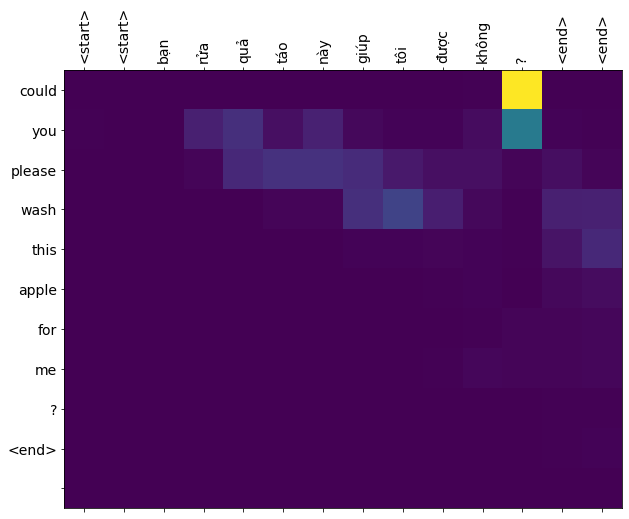

Input: <start> <start> đây là bạn của tôi tom <end> <end>
Model dịch: this is my friend tom <end> 


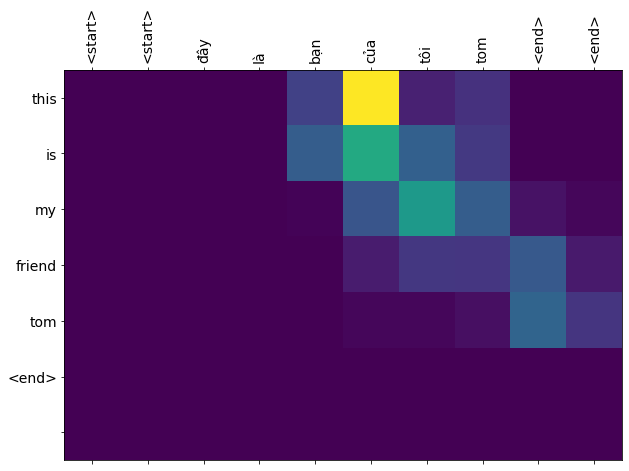

Input: <start> <start> cha của tom là một kẻ nghiện rượu <end> <end>
Model dịch: tom is a socialist <end> 


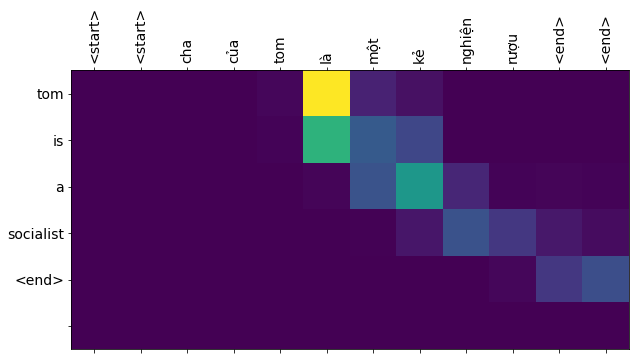

Input: <start> <start> bộ phim bắt đầu lúc 10 giờ <end> <end>
Model dịch: the silver clock at ten o clock <end> 


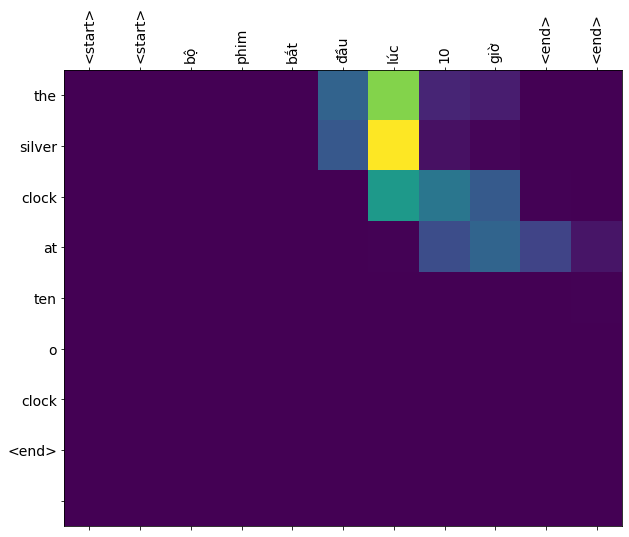

Input: <start> <start> tôi cứ tưởng họ giận tôi vì tôi không giúp họ rửa ô tô <end> <end>
Model dịch: i thought they were angry with me the car <end> 


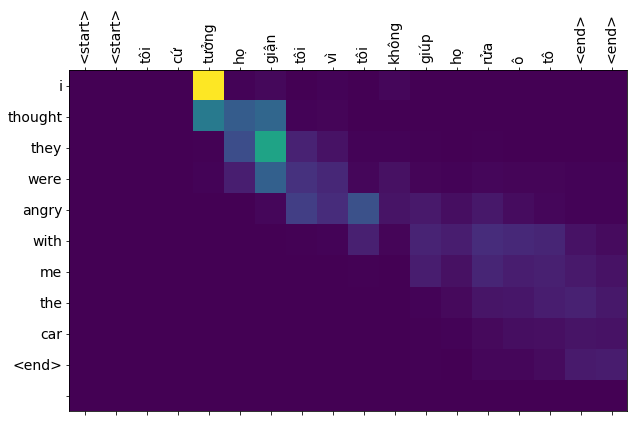

Input: <start> <start> ờ xin lỗi nghe <end> <end>
Model dịch: i m sorry <end> 


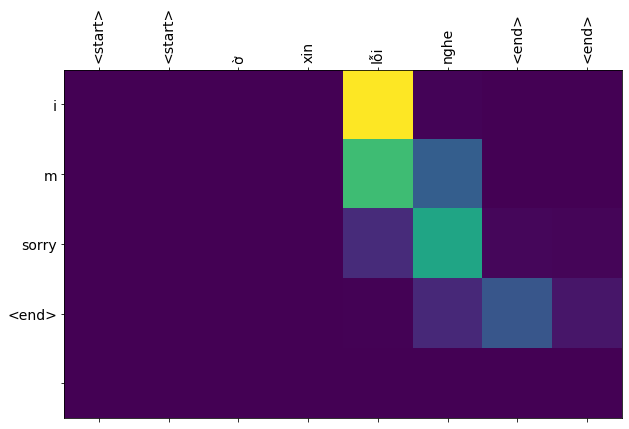

Input: <start> <start> bạn có hiểu được sự khác biệt không ? <end> <end>
Model dịch: do you understand the difference ? <end> 


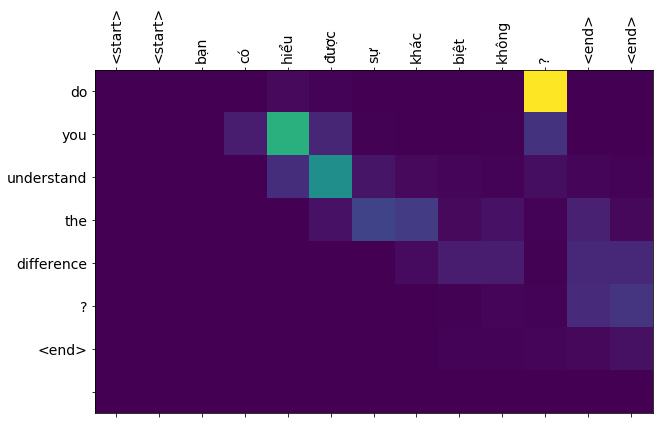

Input: <start> <start> những ai sẽ đến dự tiệc ? một vài người bạn và bốn hoặc năm đồng nghiệp <end> <end>
Model dịch: what will you ll take a few friends <end> 


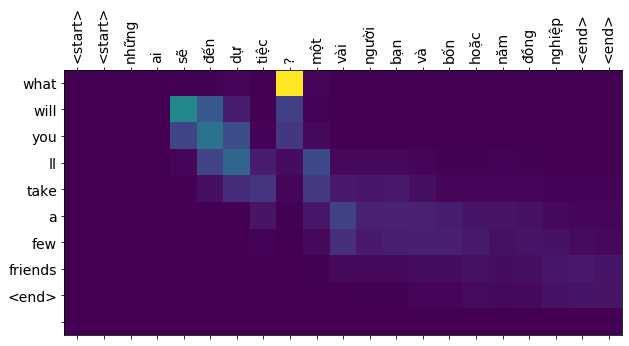

Input: <start> <start> nó là em trai tôi <end> <end>
Model dịch: he s brother <end> 


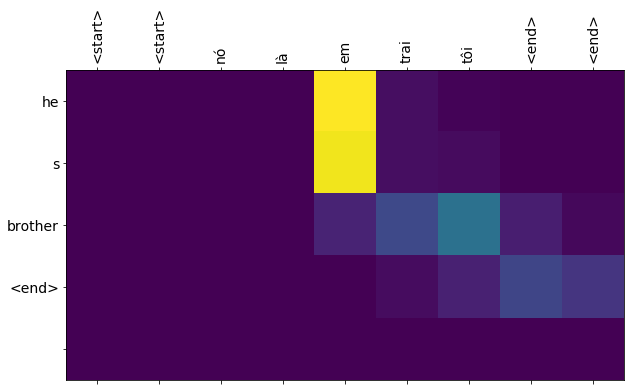

Input: <start> <start> bạn có mọi lý do để giận tôi <end> <end>
Model dịch: you have every right to be mad at me <end> 


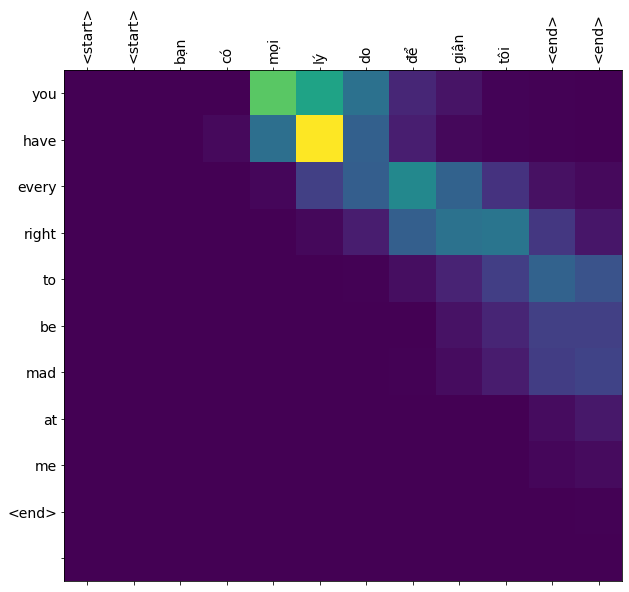

Input: <start> <start> những vị bác sĩ được tuyển vào trương trình nghiên cứu bệnh ung thư <end> <end>
Model dịch: a lot of the church every day <end> 


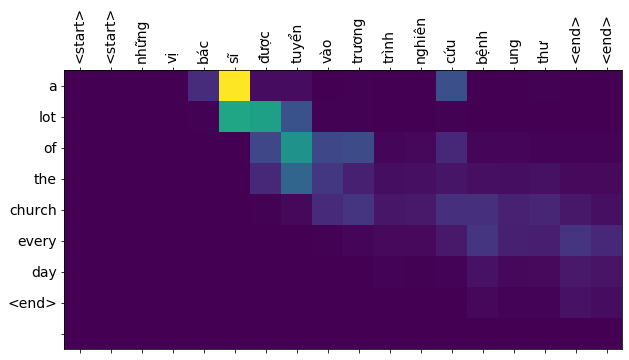

Input: <start> <start> tom ngồi cạnh mary bạn gái cũ của anh ta <end> <end>
Model dịch: tom sat across from his ex girlfriend <end> 


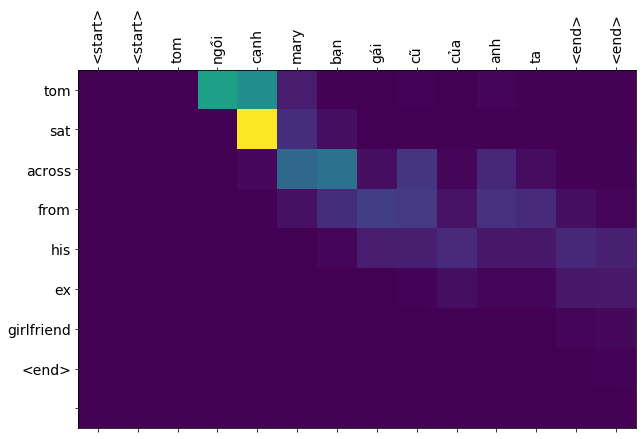

Input: <start> <start> mất bao nhiêu thời gian để đi từ đay tới ga ? <end> <end>
Model dịch: how much it take to the station ? <end> 


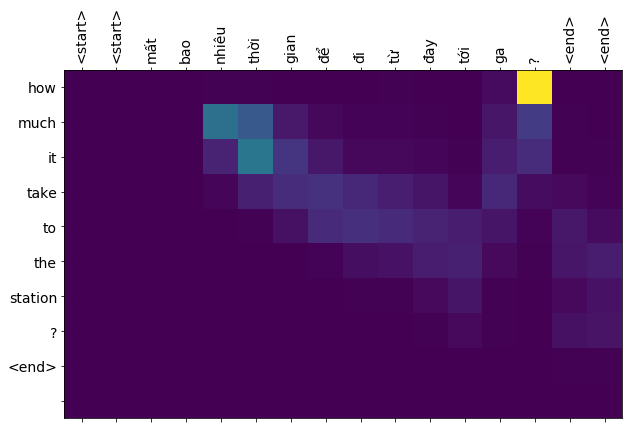

Input: <start> <start> bạn sẽ đến bữa tiệc tối nay chứ ? <end> <end>
Model dịch: are you going to the party tonight ? <end> 


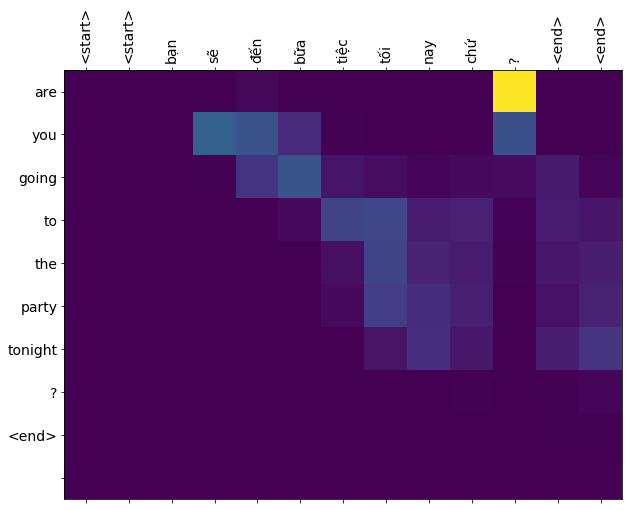

Input: <start> <start> tom đã trở nên nổi tiếng rất nhanh <end> <end>
Model dịch: tom became famous very quickly <end> 


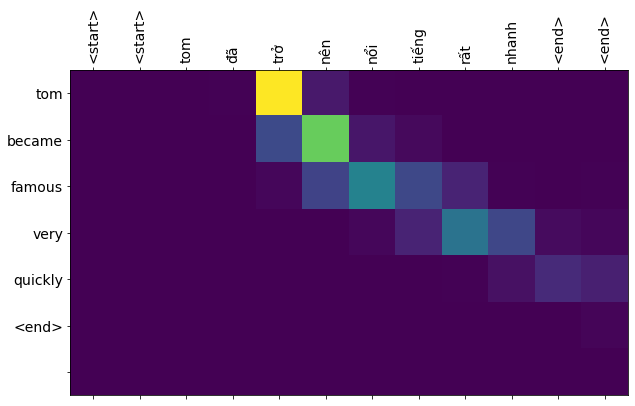

In [61]:
# Dịch 15 câu ngẫu nhiên trong dataset
for i in random_inx:
    translate(vie[i])